In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
import itertools
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from mlxtend.plotting import plot_confusion_matrix

!nvidia-smi
data_dir = '/content/drive/My Drive/Deep_assign_05/Assignment 5 Dataset/'
data_dir1 = '/content/drive/My Drive/Deep_assign_05/'


Sun Apr 26 15:24:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [52]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in

train_data = datasets.ImageFolder(data_dir + 'train/', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + 'test/', transform=test_transforms)
val_data = datasets.ImageFolder(data_dir + 'validation/', transform=test_transforms)

#data loader
trainloader      = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
testloader       = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True, num_workers=4)
validationloader = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=True, num_workers=4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [53]:
print(train_data)
print(val_data)
print(test_data)
print(trainloader)
print(testloader)
print(validationloader)

Dataset ImageFolder
    Number of datapoints: 7535
    Root location: /content/drive/My Drive/Deep_assign_05/Assignment 5 Dataset/train/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 1500
    Root location: /content/drive/My Drive/Deep_assign_05/Assignment 5 Dataset/validation/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 1500
    Root location: /content/drive/My Drive/Deep_assign_05/Assignment 5 Dataset/test/
    StandardTransform
Transfo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


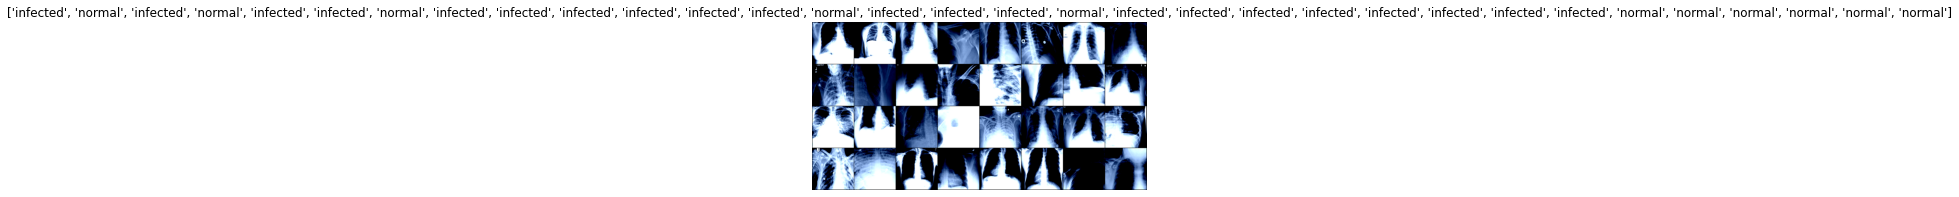

In [54]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

TASK 1

In [0]:
def get_model(a, b):
  model = 0
  out_dir = '/content/drive/My Drive/Deep_assing_05/'
  if(a == 1):
    model = models.vgg16(pretrained=True)
    fc_layers = vgg16.classifier[:4]
    fc_layers[0] = nn.Linear(in_features=25088, out_features=120)
    fc_layers[3] = nn.Linear(in_features=120, out_features=2)
    model.classifier = nn.Sequential(*fc_layers)
    if(b == 1):
      for param in model.features.parameters():
          param.requires_grad = False
    if(b == 2):
      for param in model.features[10].parameters():
          param.requires_grad = False
    return model, out_dir
    
  if(a == 2):
    model = models.resnet18(pretrained=True)
    fc_layers = []
    fc_layers.extend([nn.Linear(in_features=512, out_features=120)])
    fc_layers.extend([nn.Linear(in_features=120, out_features=2)])
    model.fc = nn.Sequential(*fc_layers)
    if(b == 1):
      for param in model.parameters():
          param.requires_grad = False
    
    return model, out_dir


In [56]:

model = get_model(2, 5)
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
def compute_acc_and_loss(model, criterion, loader):
    model.eval()
    loss_sum = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model16(images)
            loss = criterion(outputs, labels)
            loss_sum = loss_sum + loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (correct*100)/total, loss_sum/len(loader)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

In [0]:

train_loss = np.zeros(Epochs)
valid_loss = np.zeros(Epochs)

train_acc = np.zeros(Epochs)
valid_acc = np.zeros(Epochs)

for epoch in range(Epochs):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
    train_acc[epoch], train_loss[epoch] = compute_acc_and_loss(vgg16, criterion, trainloader)
    valid_acc[epoch], valid_loss[epoch] = compute_acc_and_loss(vgg16, criterion, validationloader)
    print('Train Epoch: {} \t Train acc: {:.6f} Train loss : {:.2f} \
                           \t Valid acc: {:.6f} Valid loss : {:.2f} '.format( epoch, 
                            train_acc[epoch], train_loss[epoch], 
                            valid_acc[epoch], valid_loss[epoch]))
    torch.save(model.state_dict(), 'model_ft.pth')

print('Finished Training')

In [0]:
def plot_figure(curve1, curve2, curve1_name, curve2_name, label1 = "epoch"):
    plt.figure()
    plt.plot(curve1, label = curve1_name)
    plt.plot(curve2, label = curve2_name)
    plt.xlabel(label1)
    plt.legend(loc='best')

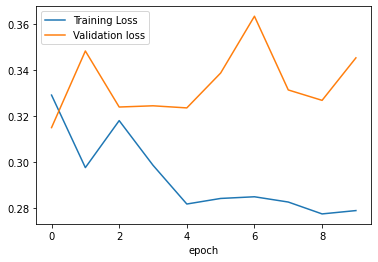

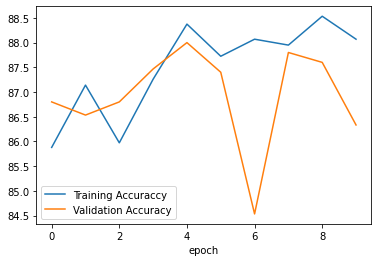

In [79]:
plot_figure(train_loss, valid_loss, "Training Loss", "Validation loss")
plot_figure(train_acc, valid_acc, "Training Accuraccy", "Validation Accuracy")
